In [1]:
# This file contaiins notebook code for client1

In [2]:
# importing all the libraries and depenedencies

!pip install -qqq pandas
!pip install -qqq scikit-learn
!pip install -qqq flwr
!pip install -qqq tensorflow

import flwr as fl
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
import math
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Dropout
# from keras.layers import Conv1D
# from tensorflow.keras.layers import MaxPool1D

# disabling warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
M_PI=3.1416
def compute_roll_yaw_pitch(x,y,z):
  #Acceleration around X
  acc_x_accl=[]

  #Acceleration around Y
  acc_y_accl=[]

  #Acceleration arounf Z
  acc_z_accl=[]


  for (x_mean,y_mean,z_mean) in zip(x,y,z):
    acc_x_accl.append(float("{:.2f}".format(x_mean*3.9)))
    acc_y_accl.append(float("{:.2f}".format(y_mean*3.9)))
    acc_z_accl.append(float("{:.2f}".format(z_mean*3.9)))


  acc_pitch=[]
  acc_roll=[]
  acc_yaw=[]

  for (acc_x,acc_y,acc_z) in zip(acc_x_accl,acc_y_accl,acc_z_accl):
    if acc_y==0 and acc_z==0:
      value_pitch=-0.1
    else:
      value_pitch=180 * math.atan (acc_x/math.sqrt(acc_y*acc_y + acc_z*acc_z))/M_PI
    if acc_x ==0 and acc_z==0:
      value_roll=-0.1
      value_yaw=-0.1
    else:
      value_roll = 180 * math.atan (acc_y/math.sqrt(acc_x*acc_x + acc_z*acc_z))/M_PI
      value_yaw = 180 * math.atan (acc_z/math.sqrt(acc_x*acc_x + acc_z*acc_z))/M_PI
    value_pitch=float("{:.2f}".format(value_pitch))
    value_roll=float("{:.2f}".format(value_roll))
    value_yaw=float("{:.2f}".format(value_yaw))
    acc_pitch.append(value_pitch)
    acc_roll.append(value_roll)
    acc_yaw.append(value_yaw)
  return acc_pitch,acc_roll,acc_yaw

In [6]:
#Sliding Window to null values
def fill_null(data):
  for col in data.columns:
    null_indexes=data[data[col].isnull()].index.tolist()
    #print("For ",col)
    for ind in null_indexes:
      #print(" Got null value at ",ind)
      values=data.loc[ind-6:ind-1,col]
      #print(" Last 5 values ",values)
      mean_val=values.mean()
      data.loc[ind,col]=mean_val
  return data

In [7]:
# loading the data

def load_data():
    user_one = "/Users/carbon/Desktop/Federated Learning/extrasensory_dataset/00EABED2-271D-49D8-B599-1D4A09240601.features_labels.csv.gz"
    # user_one="C:\\pdata\\extrasensory_dataset\\00EABED2-271D-49D8-B599-1D4A09240601.features_labels.csv.gz"
    df_one=pd.read_csv(user_one)
    #accelerometer
    df_acc=df_one.iloc[:,1:27]
    df_acc=fill_null(df_acc)
    #gyroscope
    df_gyro=df_one.iloc[:,27:53]
    df_gyro=fill_null(df_gyro)
    #magnometer
    df_magnet=df_one.iloc[:,53:84]
    df_magnet=fill_null(df_magnet)
    # watch accelerometer
    #df_watch_acc=df_one.iloc[:,84:130]
    # location
    #df_location=df_one.iloc[:,139:156]

    # For accelerometer
    #mean values
    acc_mean_x=df_acc['raw_acc:3d:mean_x']
    acc_mean_y=df_acc['raw_acc:3d:mean_y']
    acc_mean_z=df_acc['raw_acc:3d:mean_z']

    acc_mean_x=acc_mean_x.replace({0:0.001})

    #standard deviations
    #acc_std_x=df_acc['raw_acc:3d:std_x']
    #acc_std_y=df_acc['raw_acc:3d:std_y']
    #acc_std_z=df_acc['raw_acc:3d:std_z']

    (pitch,roll,yaw)=compute_roll_yaw_pitch(acc_mean_x,acc_mean_y,acc_mean_z)
    df_one['acc_pitch']=pitch
    df_one['acc_roll']=roll
    df_one['acc_yaw']=yaw

    #for gyroscope
    gyro_mean_x=df_gyro['proc_gyro:3d:mean_x']
    gyro_mean_y=df_gyro['proc_gyro:3d:mean_y']
    gyro_mean_z=df_gyro['proc_gyro:3d:mean_z']

    (pitch,roll,yaw)=compute_roll_yaw_pitch(gyro_mean_x,gyro_mean_y,gyro_mean_z)

    df_one['gyro_pitch']=pitch
    df_one['gyro_roll']=roll
    df_one['gyro_yaw']=yaw

    # For magnetometer
    magno_mean_x=df_magnet['raw_magnet:3d:mean_x']
    magno_mean_y=df_magnet['raw_magnet:3d:mean_y']
    magno_mean_z=df_magnet['raw_magnet:3d:mean_z']

    (pitch,roll,yaw)=compute_roll_yaw_pitch(magno_mean_x,magno_mean_y,magno_mean_z)

    df_one['magno_pitch']=pitch
    df_one['magno_roll']=roll
    df_one['magno_yaw']=yaw

    y=df_one[['label:FIX_running','label:FIX_walking','label:SITTING','label:SLEEPING','label:OR_standing']]

    # to avoid null values
    y['label:FIX_running']=y['label:FIX_running'].fillna(0)
    y['label:FIX_walking']=y['label:FIX_walking'].fillna(0)
    y['label:SITTING']=y['label:SITTING'].fillna(0)
    y['label:SLEEPING']=y['label:SLEEPING'].fillna(0)
    y['label:OR_standing']=y['label:OR_standing'].fillna(0)

    #Check rows where all the recorded activities are zero ~ No activity recorded rows
    list_of_indexs=[]
    for i in range(len(y)):
        run=y.iloc[i,0]
        walk=y.iloc[i,1]
        sit=y.iloc[i,2]
        sleep=y.iloc[i,3]
        stand=y.iloc[i,4]
        activities=[run,walk,sit,sleep,stand]
        count_ones=activities.count(1)
        if walk==0 and run==0 and sit==0 and sleep==0 and stand==0:
            list_of_indexs.append(i)
        #check if more then 1 exists for different activities
        elif count_ones>1:
            list_of_indexs.append(i)

    y=y.drop(list_of_indexs)
    X=df_one.iloc[:,-9:]
    X=X.drop(list_of_indexs)


    return X,y

In [85]:
def load_model_1D(X_train):
    # Create sequential model 
    cnn_model = tf.keras.models.Sequential()
    #First CNN layer  with 32 filters, conv window 3, relu activation and same padding
    cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
    #Second CNN layer  with 64 filters, conv window 3, relu activation and same padding
    cnn_model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    #Third CNN layer with 128 filters, conv window 3, relu activation and same padding
    cnn_model.add(Conv1D(filters=128, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    #Fourth CNN layer with Max pooling
    cnn_model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
    cnn_model.add(Dropout(0.5))
    #Flatten the output
    cnn_model.add(Flatten())
    #Add a dense layer with 256 neurons
    cnn_model.add(Dense(units = 256, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    #Add a dense layer with 512 neurons
    cnn_model.add(Dense(units = 512, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    #Softmax as last layer with five outputs
    cnn_model.add(Dense(units = 5, activation='softmax'))    
    return cnn_model

In [38]:
# loading the data
X,y=load_data()

In [14]:
X.head()

,acc_pitch,acc_roll,acc_yaw,gyro_pitch,gyro_roll,gyro_yaw,magno_pitch,magno_roll,magno_yaw
0,0.15,0.29,-45.0,-0.1,-0.1,-0.1,21.15,9.07,-42.95
1,0.15,0.29,-45.0,-0.1,-0.1,-0.1,21.16,9.07,-42.95
2,0.29,0.29,-45.0,-0.1,-0.1,-0.1,21.15,9.09,-42.95
3,0.29,0.29,-45.0,-0.1,-0.1,-0.1,21.15,9.09,-42.95
4,-0.44,-0.00,-45.0,-0.0,-0.0,45.0,8.15,9.10,-44.70


In [39]:
# making a single column for all the activities
y['activity']=y.idxmax(axis=1)

# convering the categorical data into numerical data
y['activity']=y['activity'].replace({'label:FIX_running':0,'label:FIX_walking':1,'label:SITTING':2,'label:SLEEPING':3,'label:OR_standing':4})

y = y['activity']
y.head()

0    2
1    2
2    2
3    2
4    2
Name: activity, dtype: int64

In [41]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

# applying decision tree classifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

# prediction
predictions = dtree.predict(X_test)

# evaluation
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.68      0.50      0.58        30
           2       0.92      0.95      0.94       224
           3       0.98      0.97      0.97        95
           4       0.73      0.77      0.75        39

    accuracy                           0.90       388
   macro avg       0.83      0.80      0.81       388
weighted avg       0.90      0.90      0.90       388



In [42]:
# overall accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.9020618556701031

In [46]:
# print model weights
print(dtree.feature_importances_)

[0.07789115 0.04291154 0.07298982 0.01924018 0.10919041 0.02069406
 0.04521377 0.11563229 0.49623678]


In [49]:
# applying k-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train)

# prediction
predictions = kmeans.predict(X_test)

# evaluation
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

# accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.04      0.33      0.07        30
           2       0.55      0.08      0.14       224
           3       0.04      0.01      0.02        95
           4       0.00      0.00      0.00        39

    accuracy                           0.07       388
   macro avg       0.12      0.08      0.04       388
weighted avg       0.33      0.07      0.09       388



0.07474226804123711

In [59]:
# print centroid labels
len(kmeans.labels_)

1551

<Axes: >

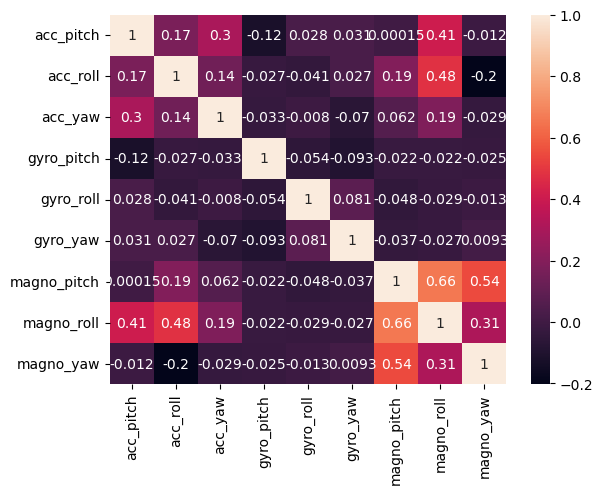

In [61]:
# heatmap of xtrain
import seaborn as sns
sns.heatmap(X_train.corr(),annot=True)

In [86]:
# Load model and data (MobileNetV2, CIFAR-10)
#model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
#model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

#load data 
(X,y)=load_data()

#reversing the one-hot encoding
a=np.array(y)
y=np.where(a)[1]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30)

#y_train=np.array(y_train).reshape(y_train.shape[0],y_train.shape[1],1)
#y_test=np.array(y_test).reshape(y_test.shape[0],y_test.shape[1],1)

model=load_model_1D(X_train)

#reshaping the arrays imply CNN
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [87]:
# Define Flower client
class CifarClient(fl.client.NumPyClient):
  def get_parameters(self, config):
    return model.get_weights()

  def fit(self, parameters, config):
    print(".... Fit Function Called ... ")
    model.set_weights(parameters)
    model.fit(X_train, y_train, epochs=60, batch_size=32)
    return model.get_weights(), len(X_train), {}

  def evaluate(self, parameters, config):
    print(".... Evaluate Function Called ... ")
    model.set_weights(parameters)
    loss, accuracy = model.evaluate(X_train, y_train)
    print("Testing accuracy is ",accuracy)
    return loss, len(X_train), {"accuracy": accuracy}

In [88]:
# # Start Flower client
# fl.client.start_numpy_client(server_address="127.0.0.1:8080", client=CifarClient())

In [89]:
# getting the model weights
orig_weights = model.get_weights()
print("Weights are ",orig_weights)

# these are the random weights

Weights are  [array([[[ 0.1145826 ,  0.03351924, -0.16182247,  0.21964487,
          0.12489375,  0.04594091, -0.09416115, -0.0680761 ,
          0.23426175,  0.2422283 , -0.19888629,  0.24280024,
         -0.00148468, -0.19160792,  0.1654157 ,  0.15751687,
          0.20340377, -0.17033806, -0.04812282, -0.1532297 ,
          0.07245156, -0.04887569, -0.12232206, -0.03778599,
         -0.01941659,  0.18454304,  0.08737907, -0.20748857,
          0.17158774,  0.03125018,  0.16895041, -0.01790337]],

       [[-0.1577645 ,  0.18745798,  0.13264892, -0.04113047,
         -0.07458445, -0.2103268 ,  0.1391097 ,  0.21802396,
         -0.2371777 ,  0.06497386,  0.23092473, -0.0386157 ,
          0.09371826, -0.05209304,  0.12902147, -0.05511111,
          0.23334453,  0.05432302,  0.13724774,  0.21479487,
         -0.00192083, -0.11189409, -0.23842473, -0.20696548,
         -0.16261697, -0.10583881, -0.1048755 ,  0.14779246,
         -0.10258554, -0.08098961, -0.03758356,  0.17752251]],

    

In [90]:
# weight dimensions
# print(weights[5].shape)

In [91]:
# Training the model

# model.set_weights(weights)
# model.fit(X_train, y_train, epochs=60, batch_size=32)

In [92]:
# to visualize the weights, take mean difference of the weights and compare overtime

In [93]:
# calculating and plotting average of weights
temp = []
for i in range(0, len(orig_weights)):
    temp.append(np.mean(orig_weights[i]))

print(np.mean(temp))

0.0021896365


In [94]:
# function to get mean value for a given set of parameters
def get_mean_param(params):
    temp = []
    for i in range(0, len(orig_weights)):
        temp.append(np.mean(orig_weights[i]))

    return (temp, np.mean(temp))
    # return temp

print(get_mean_param(orig_weights))

([0.02734604, 0.0, -0.0010094043, 0.0, 0.00026364406, 0.0, -0.00011418849, 0.0, 8.976368e-05, 0.0, -0.00030021617, 0.0], 0.0021896365)


In [95]:
# now training for different weights and storing the parameters to see their behaviour
mean_params = []
def multi_train(initial_weights, max_epochs):
    model.set_weights(initial_weights)
    mean_params.append(get_mean_param(model.get_weights()))
    for i in range(10, max_epochs+1, 10):
        model.set_weights(initial_weights)
        model.fit(X_train, y_train, epochs=i, batch_size=32) 
        mean_params.append(get_mean_param(model.get_weights()))
        print(f"Training done for {i} epochs")

multi_train(orig_weights, 20)

Epoch 1/10
43/43 [==============================] - 1s 15ms/step - loss: 1.1421 - accuracy: 0.5711
Epoch 2/10
43/43 [==============================] - 1s 12ms/step - loss: 0.6479 - accuracy: 0.7671
Epoch 3/10
43/43 [==============================] - 1s 12ms/step - loss: 0.5163 - accuracy: 0.8268
Epoch 4/10
43/43 [==============================] - 1s 12ms/step - loss: 0.5107 - accuracy: 0.8172
Epoch 5/10
43/43 [==============================] - 1s 28ms/step - loss: 0.4640 - accuracy: 0.8320
Epoch 6/10
43/43 [==============================] - 1s 22ms/step - loss: 0.4657 - accuracy: 0.8371
Epoch 7/10
43/43 [==============================] - 1s 14ms/step - loss: 0.4449 - accuracy: 0.8438
Epoch 8/10
43/43 [==============================] - 1s 17ms/step - loss: 0.4210 - accuracy: 0.8408
Epoch 9/10
43/43 [==============================] - 1s 16ms/step - loss: 0.3997 - accuracy: 0.8497
Epoch 10/10
43/43 [==============================] - 1s 14ms/step - loss: 0.4151 - accuracy: 0.8511
Training 

In [96]:
print(mean_params[0])
print(mean_params[1])
print(mean_params[2])

([0.02734604, 0.0, -0.0010094043, 0.0, 0.00026364406, 0.0, -0.00011418849, 0.0, 8.976368e-05, 0.0, -0.00030021617, 0.0], 0.0021896365)
([0.02734604, 0.0, -0.0010094043, 0.0, 0.00026364406, 0.0, -0.00011418849, 0.0, 8.976368e-05, 0.0, -0.00030021617, 0.0], 0.0021896365)
([0.02734604, 0.0, -0.0010094043, 0.0, 0.00026364406, 0.0, -0.00011418849, 0.0, 8.976368e-05, 0.0, -0.00030021617, 0.0], 0.0021896365)


In [97]:
print(model.get_weights())

[array([[[ 7.78863132e-02,  5.11122271e-02, -1.77058846e-01,
          1.86776921e-01,  1.00157849e-01,  2.74660029e-02,
         -9.19657052e-02, -4.63272631e-02,  2.65526801e-01,
          2.18862295e-01, -2.15769395e-01,  2.50752240e-01,
          2.94327959e-02, -1.94575533e-01,  1.67123020e-01,
          1.61010757e-01,  1.94804549e-01, -1.70973510e-01,
         -3.19133140e-02, -1.31538451e-01,  6.15866706e-02,
         -5.09327613e-02, -1.30830735e-01, -4.93486896e-02,
         -2.45857630e-02,  2.22160488e-01,  2.15121843e-02,
         -1.92787170e-01,  8.72197896e-02,  2.86928117e-02,
          1.51593551e-01, -1.12949731e-02]],

       [[-1.17249921e-01,  1.77664533e-01,  8.87151659e-02,
         -1.01337358e-02, -3.83041538e-02, -1.95085853e-01,
          1.03732675e-01,  2.16490731e-01, -2.20900953e-01,
          5.01779541e-02,  2.17918351e-01, -4.30636629e-02,
          8.61920193e-02, -5.52766845e-02,  1.51814446e-01,
         -3.98945697e-02,  2.40022063e-01,  5.4021511

In [98]:
print(orig_weights)

[array([[[ 0.1145826 ,  0.03351924, -0.16182247,  0.21964487,
          0.12489375,  0.04594091, -0.09416115, -0.0680761 ,
          0.23426175,  0.2422283 , -0.19888629,  0.24280024,
         -0.00148468, -0.19160792,  0.1654157 ,  0.15751687,
          0.20340377, -0.17033806, -0.04812282, -0.1532297 ,
          0.07245156, -0.04887569, -0.12232206, -0.03778599,
         -0.01941659,  0.18454304,  0.08737907, -0.20748857,
          0.17158774,  0.03125018,  0.16895041, -0.01790337]],

       [[-0.1577645 ,  0.18745798,  0.13264892, -0.04113047,
         -0.07458445, -0.2103268 ,  0.1391097 ,  0.21802396,
         -0.2371777 ,  0.06497386,  0.23092473, -0.0386157 ,
          0.09371826, -0.05209304,  0.12902147, -0.05511111,
          0.23334453,  0.05432302,  0.13724774,  0.21479487,
         -0.00192083, -0.11189409, -0.23842473, -0.20696548,
         -0.16261697, -0.10583881, -0.1048755 ,  0.14779246,
         -0.10258554, -0.08098961, -0.03758356,  0.17752251]],

       [[ 0.18344

In [99]:
# when we start with same initial parameters it converges. When given any other set it does not.
# However the mean remains same


In [100]:
# now training for different weights and storing the parameters to see their behaviour
mean_params = []
def multi_train(initial_weights, max_epochs):
    model.set_weights(initial_weights)
    mean_params.append(get_mean_param(model.get_weights()))
    for i in range(10, max_epochs+1, 10):
        # model.set_weights(initial_weights)
        model.fit(X_train, y_train, epochs=i, batch_size=32) 
        mean_params.append(get_mean_param(model.get_weights()))
        print(f"Training done for {i} epochs")

multi_train(orig_weights, 20)

Epoch 1/10
43/43 [==============================] - 1s 15ms/step - loss: 1.0104 - accuracy: 0.6293
Epoch 2/10
43/43 [==============================] - 1s 13ms/step - loss: 0.6758 - accuracy: 0.7480
Epoch 3/10
43/43 [==============================] - 1s 12ms/step - loss: 0.5014 - accuracy: 0.8298
Epoch 4/10
43/43 [==============================] - 1s 16ms/step - loss: 0.4678 - accuracy: 0.8386
Epoch 5/10
43/43 [==============================] - 1s 13ms/step - loss: 0.4639 - accuracy: 0.8349
Epoch 6/10
43/43 [==============================] - 1s 14ms/step - loss: 0.4343 - accuracy: 0.8445
Epoch 7/10
43/43 [==============================] - 1s 14ms/step - loss: 0.4355 - accuracy: 0.8423
Epoch 8/10
43/43 [==============================] - 1s 12ms/step - loss: 0.4219 - accuracy: 0.8460
Epoch 9/10
43/43 [==============================] - 1s 12ms/step - loss: 0.4117 - accuracy: 0.8511
Epoch 10/10
43/43 [==============================] - 1s 15ms/step - loss: 0.3818 - accuracy: 0.8592
Training 

In [101]:
print(mean_params[0])
print(mean_params[1])
print(mean_params[2])

([0.02734604, 0.0, -0.0010094043, 0.0, 0.00026364406, 0.0, -0.00011418849, 0.0, 8.976368e-05, 0.0, -0.00030021617, 0.0], 0.0021896365)
([0.02734604, 0.0, -0.0010094043, 0.0, 0.00026364406, 0.0, -0.00011418849, 0.0, 8.976368e-05, 0.0, -0.00030021617, 0.0], 0.0021896365)
([0.02734604, 0.0, -0.0010094043, 0.0, 0.00026364406, 0.0, -0.00011418849, 0.0, 8.976368e-05, 0.0, -0.00030021617, 0.0], 0.0021896365)


In [102]:
print(model.get_weights())

[array([[[ 0.10950692,  0.05223698, -0.21123224,  0.18965785,
          0.13030855,  0.0735609 , -0.06040355, -0.05173438,
          0.27659288,  0.23098372, -0.2248499 ,  0.24292496,
          0.03507252, -0.21721013,  0.16367024,  0.16435477,
          0.20420279, -0.15833434, -0.04345402, -0.14906983,
          0.04533484, -0.05925493, -0.12897816, -0.05827384,
         -0.04116195,  0.1877517 ,  0.06456325, -0.19953266,
          0.09298431,  0.03540746,  0.1335078 ,  0.00416312]],

       [[-0.12593666,  0.18193895,  0.07732977, -0.01772696,
         -0.02999177, -0.1800256 ,  0.17152971,  0.2203641 ,
         -0.21659543,  0.05596207,  0.22258352, -0.03230125,
          0.08486009, -0.05560613,  0.11937154, -0.02189283,
          0.25102946,  0.04261348,  0.12551819,  0.23240195,
         -0.01890196, -0.06366076, -0.22109222, -0.20832177,
         -0.13930777, -0.08930306, -0.06583678,  0.18558754,
         -0.10142419, -0.0623186 , -0.03756332,  0.18768123]],

       [[ 0.20309